Use BIDS data, do plotting of interpolation, use reset_settings and manually selecting features, do sharpwave analysis and external ML model


# Beyond example_BIDS.py

This notebook is going to follow some steps already explained in example_BIDS.ipynb, but with two extensions:
1. Show how the user can plot
2. Show how the user can use their preferred Machine Learning method

Again we start with importing the necessary packages:

In [1]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if SCRIPT_DIR.split("/")[-1] == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
)
from sklearn import metrics, model_selection
from skopt import space as skopt_space

## Read BIDS data

For an example with simulated data, please look into example_SimulatedData

In [3]:
sub = "testsub"
ses = "EphysMedOff"
task = "buttonpress"
run = 0
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = os.path.join(SCRIPT_DIR, "data")

# Provide a path for the output data.
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives")

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

Extracting parameters from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_acq-StimOff_space-mni_electrodes.tsv.


## Define the channels

In [4]:
nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=("SQUARED_ROTATION",),
)

In [5]:
nm_channels

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,average,1,0,ecog,good,ECOG_L_1_SMC_AT-avgref
2,ECOG_L_2_SMC_AT,average,1,0,ecog,good,ECOG_L_2_SMC_AT-avgref
3,ECOG_L_3_SMC_AT,average,1,0,ecog,good,ECOG_L_3_SMC_AT-avgref
4,ECOG_L_4_SMC_AT,average,1,0,ecog,good,ECOG_L_4_SMC_AT-avgref
5,ECOG_L_5_SMC_AT,average,1,0,ecog,good,ECOG_L_5_SMC_AT-avgref
6,ECOG_L_6_SMC_AT,average,1,0,ecog,good,ECOG_L_6_SMC_AT-avgref
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,LFP_L_567_STN_BS,1,0,seeg,good,LFP_L_1_STN_BS-LFP_L_567_STN_BS
9,LFP_L_234_STN_BS,LFP_L_1_STN_BS,1,0,seeg,good,LFP_L_234_STN_BS-LFP_L_1_STN_BS


The data contains depth LFP electrodes from the Subthalamic Nucleus (STN) and a ECoG strip electrode. Bipolar rereferencing was defined by default for the depth electrodes, and common average rereference for the ECoG electrodes. Importantly "SQUARED_ROTATION" is used as a target channel. After feature estimation, this channel will be normalized and added in a time aligned manner to the features output csv file.

## Feature Estimation

In [6]:
stream = nm.Stream(
    settings=None,
    nm_channels=nm_channels,
    path_grids=None,
    verbose=True,
)

When the Stream class is initialized with "settings=None", the settings for the feature estimation are imported from the nm_settings.json file. In the cell below we display those settings:

In [7]:
stream.settings

{'sampling_rate_features_hz': 10,
 'segment_length_features_ms': 1000,
 'preprocessing': {'raw_resampling': True,
  'raw_normalization': True,
  're_referencing': True,
  'notch_filter': True,
  'preprocessing_order': ['raw_resampling',
   'notch_filter',
   're_referencing',
   'raw_normalization']},
 'features': {'raw_hjorth': True,
  'return_raw': True,
  'bandpass_filter': True,
  'stft': True,
  'fft': True,
  'sharpwave_analysis': True,
  'coherence': True,
  'fooof': True,
  'nolds': True,
  'bursts': True},
 'postprocessing': {'feature_normalization': True,
  'project_cortex': True,
  'project_subcortex': True},
 'raw_resampling_settings': {'resample_freq_hz': 1000},
 'raw_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'frequency_ranges_hz': {'theta': [4, 8],
  'alpha': [8, 12],
  'low beta': [13, 20],
  'hig

Now, if the user wants to use a different set of settings, they can either change the nm_settings.json file, or from the script alter them.

Here, we first use stream.reset_settings(), which sets the preprocessing steps to false, as well as the desired features and the postprocessing steps. In that way, we need to select all steps from preprocessing, feature estimation and postprocessing that we want to perform.

In [8]:
stream.reset_settings()
stream.settings

{'sampling_rate_features_hz': 10,
 'segment_length_features_ms': 1000,
 'preprocessing': {'raw_resampling': False,
  'raw_normalization': False,
  're_referencing': False,
  'notch_filter': False,
  'preprocessing_order': []},
 'features': {'raw_hjorth': False,
  'return_raw': False,
  'bandpass_filter': False,
  'stft': False,
  'fft': False,
  'sharpwave_analysis': False,
  'coherence': False,
  'fooof': False,
  'nolds': False,
  'bursts': False},
 'postprocessing': {'feature_normalization': False,
  'project_cortex': False,
  'project_subcortex': False},
 'raw_resampling_settings': {'resample_freq_hz': 1000},
 'raw_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'frequency_ranges_hz': {'theta': [4, 8],
  'alpha': [8, 12],
  'low beta': [13, 20],
  'high beta': [20, 35],
  'low gamma': [60, 80],
  'high gamma': [90

Now we manually set to True all steps that we want to be performed in the feature estimation.

In [9]:
# We first take care of the preprocessing steps - and here we want to perform all of them in the order given by stream.settings['preprocessing']['preprocessing_order']

stream.settings['preprocessing']['raw_resampling'] = True
stream.settings['preprocessing']['raw_normalization'] = True
stream.settings['preprocessing']['re_referencing'] = True
stream.settings['preprocessing']['notch_filter'] = True
stream.settings['preprocessing']['preprocessing_order'] = [
            "raw_resampling",
            "notch_filter",
            "re_referencing",
            "raw_normalization"
        ]

# Now we focus on the features that we want to estimate:

stream.settings['features']['raw_hjorth'] = True
stream.settings['features']['bandpass_filter'] = True
stream.settings['features']['fft'] = True
stream.settings['features']['sharpwave_analysis'] = True
stream.settings['features']['fooof'] = True

# Then we set the postprocessing steps
stream.settings['postprocessing']['feature_normalization'] = False
stream.settings['postprocessing']['project_cortex'] = True
stream.settings['postprocessing']['project_subcortex'] = True

One can also change the settings related to those steps by accessing the correspondent keys, for example:

In [10]:
# One can also change the settings related to those steps, for example:
stream.settings['bandpass_filter_settings']["kalman_filter"] = True

In [11]:
# Now we can check the final settings before running the analysis:
stream.settings

{'sampling_rate_features_hz': 10,
 'segment_length_features_ms': 1000,
 'preprocessing': {'raw_resampling': True,
  'raw_normalization': True,
  're_referencing': True,
  'notch_filter': True,
  'preprocessing_order': ['raw_resampling',
   'notch_filter',
   're_referencing',
   'raw_normalization']},
 'features': {'raw_hjorth': True,
  'return_raw': False,
  'bandpass_filter': True,
  'stft': False,
  'fft': True,
  'sharpwave_analysis': True,
  'coherence': False,
  'fooof': True,
  'nolds': False,
  'bursts': False},
 'postprocessing': {'feature_normalization': False,
  'project_cortex': True,
  'project_subcortex': True},
 'raw_resampling_settings': {'resample_freq_hz': 1000},
 'raw_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'frequency_ranges_hz': {'theta': [4, 8],
  'alpha': [8, 12],
  'low beta': [13, 20],


And then we run the analysis:

In [12]:
stream.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

Last batch took: 0.38 seconds
1.0 seconds of data processed
Last batch took: 0.28 seconds
1.1 seconds of data processed
Last batch took: 0.37 seconds
1.2 seconds of data processed
Last batch took: 0.45 seconds
1.3 seconds of data processed
Last batch took: 0.34 seconds
1.4 seconds of data processed
Last batch took: 0.41 seconds
1.5 seconds of data processed
Last batch took: 0.3 seconds
1.6 seconds of data processed
Last batch took: 0.34 seconds
1.7 seconds of d

## Analysing results

In [13]:
# init analyzer
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = feature_reader.nm_channels.query(
    '(type=="ecog") and (used == 1)'
).iloc[0]["name"]

feature_used = (
    "stft" if feature_reader.settings["features"]["stft"] else "fft"
)

In [14]:
ch_cols = [f_ for f_ in feature_reader.feature_arr.columns if ch_used in f_]

In [15]:
feature_reader.feature_arr[ch_cols].T

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
ECOG_L_1_SMC_AT-avgref_RawHjorth_Activity,556.867448,1.062234,0.993621,0.943920,0.928492,0.852230,0.700516,0.485655,0.458538,0.429905,...,0.787498,0.825906,0.807649,0.823140,0.839660,0.875233,1.044616,1.018915,1.285753,1.539734
ECOG_L_1_SMC_AT-avgref_RawHjorth_Mobility,0.097928,0.097870,0.101644,0.101334,0.102008,0.105832,0.115610,0.139348,0.145471,0.149273,...,0.141883,0.139187,0.139578,0.137808,0.133944,0.133092,0.122830,0.123291,0.109791,0.096855
ECOG_L_1_SMC_AT-avgref_RawHjorth_Complexity,12.191996,12.082133,11.731426,12.208543,12.168375,11.595645,10.853060,9.157952,8.705997,8.503853,...,8.241083,8.438267,8.520615,8.531605,8.693385,8.692532,9.221154,9.360012,10.225929,12.085410
ECOG_L_1_SMC_AT-avgref_bandpass_activity_theta,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_alpha,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_low beta,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_high beta,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_low gamma,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_high gamma,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_HFA,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147


Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_ECOG_L_1_SMC_AT_fft.png


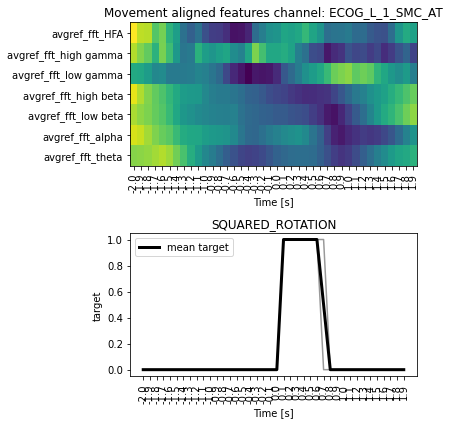

In [16]:
feature_reader.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)